In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Performance Improvement Technique

## Prevent Overfitting

1. Data Augmentation

2. L2 Regularization

3. Dropout

4. Batch Normalization

5. Disturb Label (used when classfication task)

In [ ]:
class DisturbLabel(nn.Module):
  def __init__(self, alpha, num_classes):
    super(DisturbLabel, self).__init__()
    self.alpha = alpha
    self.C = num_classes
    self.p_c = (1 - ((self.C - 1) / self.C) * (alpha / 100))
    self.p_i = (1 - self.p_c) / (self.C - 1)

  def forward(self, y):
    y_tensor = y.type(torch.LongTensor).view(-1, 1)
    depth = self.C
    y_one_hot = torch.ones(y_tensor.size()[0], depth) * self.p_i
    y_one_hot.scatter_(1, y_tensor, self.p_c)
    y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,)))
    distribution = torch.distributions.OneHotCategorical(y_one_hot)
    y_disturbed = distribution.sample()
    y_disturbed = y_disturbed.max(dim=1)[1]
    return y_disturbed

In [ ]:
disturblabels = DisturbLabel(alpha=30, num_classes=10)

In [ ]:
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    labels = disturblabels(labels).to(device)
    loss = criterion(outputs, labels)
    # ...... 이하 생략 ......

6. Disturb Value (used when regression task)

In [ ]:
def noise_generator(x, alpha):
  noise = torch.normal(0, 1e-8, size=(len(x), 1))
  noise[torch.randint(0, len(x), (int(len(x) * (1 - alpha)),))] = 0
  return noise

In [ ]:
for epoch in range(400):
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    values = values + noise_generator(values, alpha)
    loss =criterion(outputs, values)
    # ...... 이하 생략 ......

7. Label Smoothing

\begin{align}
  y_{ls} = (1 - α)y\hspace{0.2cm}+\hspace{0.2cm} \frac{α}{K}
  \\(K는 클래스 수, α는 스무딩 비율, y는 0 또는 1)
\end{align}

In [ ]:
class LabelSmoothingLoss(nn.Module):
  def __init__(self, classes, smoothing=0.0, dim=-1):
    super(LabelSmoothingLoss, self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim
  
  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim)
    with torch.no_grad():
      true_dist = torch.zeros_like(pred)
      true_dist.fill_(self.smoothing / (self.cls - 1))
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
criterion = LabelSmoothingLoss(classes=10, smoothing=0.2)

## Resolved Data Imvalanced

design for dataloader

In [ ]:
def make_weights(labels, nclasses):
  labels = np.array(labels)
  weight_list = []
  for cls in range(nclasses):
    idx = np.where(labels == cls)[0]
    count = len(idx)
    weight = 1 / count
    weights = [weight] * count
    weight_list += weights
  return weight_list

In [ ]:
transf = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True,  transform=transf)

weights = make_weights(trainset.targets, len(trainset.classes))
weights = torch.DoubleTensor(weights)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
trainloader_wrs = DataLoader(trainset, batch_size=6, sampler=sampler)
trainloader_rs = DataLoader(trainset, batch_size=6, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
for idx, data in enumerate(trainloader_wrs):
  print(data[1])
  if idx == 5: break
print("="*15)
for idx, data in enumerate(trainloader_rs):
  print(data[1])
  if idx == 5: break

# 뭐 대충 비율 알맞게 나온다고 한다.

tensor([5, 0, 4, 3, 3, 4])
tensor([5, 2, 9, 4, 4, 2])
tensor([2, 6, 4, 6, 7, 3])
tensor([5, 1, 7, 3, 2, 5])
tensor([6, 8, 6, 3, 5, 1])
tensor([4, 8, 6, 6, 2, 0])
tensor([1, 1, 9, 3, 2, 5])
tensor([4, 2, 1, 4, 3, 3])
tensor([1, 7, 4, 7, 9, 2])
tensor([0, 2, 8, 1, 1, 4])
tensor([6, 1, 2, 3, 1, 8])
tensor([5, 0, 5, 4, 6, 3])


function of nn.CrossEntropyLoss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
num_ins = [40, 35, 20, 65, 70, 153, 408, 43, 58, 183, 590] # lenght of each classes
weights = [(1 - (x / sum(num_ins)) for x in num_ins)]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Confusion Matrix : for result analysis, not for directly resolved data imblance problem

대각 성분이 짙으면 예측을 잘한거다.

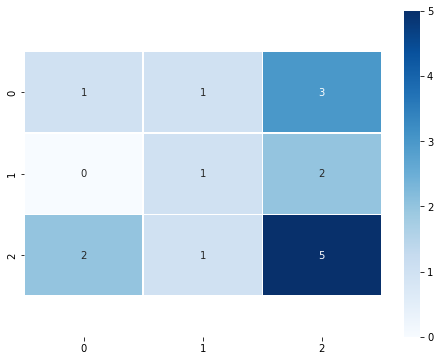

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual = [1,1,1,0,0,0,0,0,2,2,2,2,2,2,2,2]
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2,2]
c_mat = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", linewidths=.5)
b, t = plt.ylim()
b += .5
t -= .5
plt.ylim(b, t)
plt.savefig("/content/confusion_matrix.png")
plt.show()
# 예측값이 2에 많이 치우친 것을 알 수 있다. 
# 이를 통해서 2가 상대적으로 과적합 되었다는 해석을 추가적으로 할 수 있다.

## Transfer Learning

Pre-trained Models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet().to(device)
resnet18 = models.resnet18().to(device)
vgg16 = models.vgg16().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)
googlenet = models.googlenet().to(device)
shufflenet = models.shufflenet_v2_x1_0().to(device)
mobilenet_v2 = models.mobilenet_v2().to(device)
resnext50_32x4d = models.resnext50_32x4d().to(device)
wide_resnet50_2 = models.wide_resnet50_2().to(device)
mnasnet = models.mnasnet1_0().to(device)

In [ ]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fx = nn.Linear(num_ftrs, 10)
model = model.to(device)

Model Freezing

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# freezing parameters
for i, (name, param) in enumerate(model.named_parameters()):
  param.requires_grad = False
  if i == 9:
    print("end!")
    break

end!


In [ ]:
# check freezing
f_list = [0, 3, 6, 8, 10]
c_list = [1, 4, 6]

for i in f_list:
  print(i, name, model.features[i].weight.requires_grad)
  print(i, name, model.features[i].bias.requires_grad)

for i in c_list:
  print(i, name, model.classifier[i].weight.requires_grad)
  print(i, name, model.classifier[i].bias.requires_grad)

0 classifier.6.bias False
0 classifier.6.bias False
3 classifier.6.bias False
3 classifier.6.bias False
6 classifier.6.bias False
6 classifier.6.bias False
8 classifier.6.bias False
8 classifier.6.bias False
10 classifier.6.bias False
10 classifier.6.bias False
1 classifier.6.bias True
1 classifier.6.bias True
4 classifier.6.bias True
4 classifier.6.bias True
6 classifier.6.bias True
6 classifier.6.bias True


## Semi-supervised Learning

Pseudo Labeling

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyDataset(Dataset):
  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

class TrainTransform:
  def __call__(self, sample):
    inputs, labels = sample
    transf = transforms.Compose([
                                 transforms.ToPILImage(), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor()])
    final_output = transf(inputs)
    return final_output, labels

In [ ]:
def balanced_subset(data, labels, num_cls, num_data):
  num_data_per_class = num_data // num_cls
  data1 = torch.tensor([], dtype=torch.float)
  data2 = torch.tensor([], dtype=torch.float)
  labels1 = torch.tensor([], dtype=torch.long)
  labels2 = torch.tensor([], dtype=torch.long)
  for cls in range(num_cls):
    idx = np.where(labels.numpy() == cls)[0]
    shuffled_idx = np.random.choice(len(idx), len(idx), replace=False)
    data1 = torch.cat([data1, data[shuffled_idx[:num_data_per_class]]], dim=0)
    data2 = torch.cat([data2, data[shuffled_idx[num_data_per_class:]]], dim=0)
    labels1 = torch.cat([labels1, labels[shuffled_idx[:num_data_per_class]]], dim=0)
    labels2 = torch.cat([labels2, labels[shuffled_idx[num_data_per_class:]]], dim=0)
  return data1, data2, labels1, labels2

In [ ]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True)
labeled_data, unlabeled_data, labels, unlabels = balanced_subset(trainset.data, trainset.targets, num_cls=10, num_data=2000)
train_images, val_images, train_labels, val_labels = balanced_subset(labeled_data, labels, num_cls=10, num_data=1000)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_images = train_images.unsqueeze(1)
val_images = val_images.unsqueeze(1)
trainset = MyDataset(train_images, train_labels, transform=TrainTransform())
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
validationset = MyDataset(val_images, val_labels)
valloader = DataLoader(validationset, batch_size=128, shuffle=False)
unlabeled_images = unlabeled_data.unsqueeze(1)
unlabeledset = MyDataset(unlabeled_images, unlabels)
unlabeledloader = DataLoader(unlabeledset, batch_size=256, shuffle=True)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 64, 3), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2, 2))
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(192*6*6, 1024), nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512, 10))
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 192*6*6)
    x = self.classifier(x)
    return x

In [ ]:
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  model.train()
  return acc

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

Supervised Learning Model for Pseudo Labaling Model Baseline

In [ ]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
best_acc = 0
for epoch in range(501):
  correct = 0
  total = 0
  for traindata in trainloader:
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 18.50, validation acc: 23.40 - Saved the best model
[1] train acc: 40.00, validation acc: 43.80 - Saved the best model
[2] train acc: 48.80, validation acc: 55.20 - Saved the best model
[10] train acc: 94.20, validation acc: 50.00
[11] train acc: 95.40, validation acc: 56.00 - Saved the best model
[12] train acc: 95.90, validation acc: 59.50 - Saved the best model
[20] train acc: 99.20, validation acc: 59.80 - Saved the best model
[27] train acc: 99.50, validation acc: 60.70 - Saved the best model
[29] train acc: 99.70, validation acc: 61.30 - Saved the best model
[30] train acc: 99.80, validation acc: 56.70
[32] train acc: 99.90, validation acc: 62.20 - Saved the best model
[40] train acc: 99.80, validation acc: 53.90
[41] train acc: 99.80, validation acc: 67.60 - Saved the best model
[50] train acc: 98.90, validation acc: 66.20
[53] train acc: 99.70, validation acc: 67.90 - Saved the best model
[57] train acc: 99.80, validation acc: 72.60 - Saved the best model
[60] tr

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt"))
accuracy(testloader)

78.95

Semi-supervised Learning Model 1

모델이 일정 수준 학습되면 라벨링이 안된 데이터 또한 예측시키고 나온 예측값과 예측값을 max를 취한 값으로 cost를 계산하여 학습하는 방법.

In [ ]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
alpha = 0
alpha_t = 1e-4
T1 = 100
T2 = 450
best_acc = 0

In [ ]:
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, unlabeledloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs = pseudodata[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    if alpha > 0:
      poutputs = model(pinputs)
      _, plabels = torch.max(poutputs.detach(), 1)
      loss = criterion(outputs, labels) + alpha * criterion(poutputs, plabels)
    else:
      loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t * (epoch - T1) / (T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label1.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 15.50, validation acc: 26.30 - Saved the best model
[1] train acc: 38.90, validation acc: 40.20 - Saved the best model
[2] train acc: 48.80, validation acc: 41.60 - Saved the best model
[4] train acc: 66.40, validation acc: 55.30 - Saved the best model
[7] train acc: 84.90, validation acc: 60.50 - Saved the best model
[8] train acc: 89.00, validation acc: 62.30 - Saved the best model
[9] train acc: 92.10, validation acc: 66.30 - Saved the best model
[10] train acc: 92.80, validation acc: 65.40
[12] train acc: 95.00, validation acc: 68.00 - Saved the best model
[15] train acc: 98.90, validation acc: 70.80 - Saved the best model
[16] train acc: 98.70, validation acc: 70.80 - Saved the best model
[19] train acc: 99.20, validation acc: 74.10 - Saved the best model
[20] train acc: 99.50, validation acc: 73.60
[21] train acc: 99.90, validation acc: 74.30 - Saved the best model
[22] train acc: 99.10, validation acc: 81.30 - Saved the best model
[30] train acc: 99.70, validation

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label1.pt"))
accuracy(testloader)

79.08

Semi-supervised Learning Model 2

라벨링이 된 데이터로 지도 학습된 모델을 이용하여 의사 라벨을 만들어 학습하는 방법

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
pseudo_threshold = 0.99
pseudo_images = torch.tensor([], dtype=torch.float)
pseudo_labels = torch.tensor([], dtype=torch.long)
with torch.no_grad():
  for data in tqdm(unlabeledloader):
    model.eval()
    images = data[0].to(device)
    outputs = model(images)
    outputs = F.softmax(outputs, dim=1)
    max_val, predicted = torch.max(outputs.detach(), 1)
    idx = np.where(max_val.cpu().numpy() >= pseudo_threshold)[0]
    if len(idx) > 0:
      pseudo_images = torch.cat((pseudo_images, images.cpu()[idx]), 0)
      pseudo_labels = torch.cat((pseudo_labels, predicted.cpu()[idx]), 0)

100%|██████████| 227/227 [00:07<00:00, 32.04it/s]


In [ ]:
pseudo_dataset = MyDataset(pseudo_images, pseudo_labels)
pseudoloader = DataLoader(pseudo_dataset, batch_size=256, shuffle=True)

In [ ]:
alpha = 0
alpha_t = 1e-4
T1 = 100
T2 = 450
best_acc = 0

In [ ]:
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, pseudoloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs, plabels = pseudodata[0].to(device), pseudodata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    poutputs = model(pinputs)
    loss = criterion(outputs, labels) + alpha * criterion(poutputs, plabels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t * (epoch - T1) / (T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label2.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 100.00, validation acc: 57.90 - Saved the best model
[1] train acc: 99.70, validation acc: 76.50 - Saved the best model
[10] train acc: 99.90, validation acc: 65.30
[13] train acc: 99.80, validation acc: 82.00 - Saved the best model
[20] train acc: 99.30, validation acc: 80.10
[30] train acc: 99.90, validation acc: 74.50
[35] train acc: 99.80, validation acc: 83.80 - Saved the best model
[36] train acc: 100.00, validation acc: 84.30 - Saved the best model
[40] train acc: 100.00, validation acc: 77.90
[50] train acc: 99.50, validation acc: 74.70
[60] train acc: 99.90, validation acc: 80.20
[70] train acc: 99.60, validation acc: 75.60
[80] train acc: 100.00, validation acc: 67.60
[90] train acc: 100.00, validation acc: 71.50
[100] train acc: 100.00, validation acc: 78.40
[103] train acc: 100.00, validation acc: 84.50 - Saved the best model
[104] train acc: 100.00, validation acc: 88.80 - Saved the best model
[110] train acc: 100.00, validation acc: 86.50
[120] train acc: 1

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label2.pt"))
accuracy(testloader)

75.4

결과적으로 1번 준지도 학습 방법이 성능을 향상시켰다. 2번 준지도 학습의 경우 부정확한 라벨링으로 때문에 성능 저하가 발생한듯 하다.